### Import libraries 

In [27]:
import numpy as np
from glob import glob
import os.path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate
import sys
sys.path.append('../')
from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
from keras_vision_transformer import utils
import matplotlib.pyplot as plt
%matplotlib inline

###  Swin Transformer and data processing functions defination

In [28]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array)
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, 
                   labelbottom=False, left=False, right=False, labelleft=False)
    return ax


### Initilization of Hyper Parameters

In [29]:
filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

### Input and Model Defination 

In [94]:
# Input section
input_size = (128,128,3)
IN = Input(input_size)

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, 
                      shift_window=shift_window, name='swin_unet')
n_labels = 2
OUT = Conv2D(n_labels, kernel_size=1, use_bias=False, activation='softmax')(X)
model = Model(inputs=[IN,], outputs=[OUT,])
opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt)

### Loading image and annotations and train, validation, test split 

In [95]:
sample_names = np.array(sorted(glob('data/images/*.jpg')))

label_names = np.array(sorted(glob('data/mask_png/*.png')))


L = len(sample_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]
ind_valid = ind_all[L_train:L_train+L_valid]
ind_test = ind_all[L_train+L_valid:]
print(ind_test)
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))
valid_input = input_data_process(utils.image_to_array(sample_names[ind_valid], size=128, channel=3))
valid_target = target_data_process(utils.image_to_array(label_names[ind_valid], size=128, channel=1))
print(valid_target.shape)
test_input = input_data_process(utils.image_to_array(sample_names[ind_test], size=128, channel=3))

test_target = target_data_process(utils.image_to_array(label_names[ind_test], size=128, channel=1))
print(np.unique(test_target))

[109   3  63 132  38 107 181  40 159  56  16  45 162 190  32 142  99  21
 174  61  53]
Training:validation:testing = 156:19:21
(19, 128, 128, 2)
[0. 1.]


### Model Traning 

In [125]:
N_epoch = 200 # number of epoches
N_batch = 32 # number of batches per epoch
N_sample = 16# number of samples per batch
tol = 0       # current early stopping patience
max_tol = 10 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 
for epoch in range(N_epoch):
    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_target,])
#         if np.isnan(loss_):
#             print("Training blow-up")

        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

1/1 [==============================] - 0s 65ms/step
	Initial loss = 0.8623799681663513
1/1 [==============================] - 0s 68ms/step
Validation performance 0.8656846880912781 is NOT improved
1/1 [==============================] - 0s 66ms/step
Validation performance 0.8797863125801086 is NOT improved
1/1 [==============================] - 0s 73ms/step
Validation performance 0.8944191932678223 is NOT improved
1/1 [==============================] - 0s 66ms/step
Validation performance 0.8840276002883911 is NOT improved
1/1 [==============================] - 0s 70ms/step
Validation performance 0.9032564759254456 is NOT improved
1/1 [==============================] - 0s 66ms/step
Validation performance 0.9048234224319458 is NOT improved
1/1 [==============================] - 0s 72ms/step
Validation performance 0.9104130268096924 is NOT improved
1/1 [==============================] - 0s 71ms/step
Validation performance 0.92214435338974 is NOT improved
1/1 [==============================

### Evaluation

#### The testing set performance is evaluated.

In [126]:
print(test_input.shape)
y_pred = model.predict([test_input,])
print(y_pred.shape)
print(test_target.shape)


print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target, y_pred))))

acc = keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
acc.update_state(test_target,y_pred)
print('Testing set Accuracy = ',acc.result().numpy())


(21, 128, 128, 3)
1/1 [==============================] - 0s 72ms/step
(21, 128, 128, 2)
(21, 128, 128, 2)
Testing set cross-entropy loss = 1.6243330240249634
Testing set Accuracy =  0.876491


**Example of outputs**

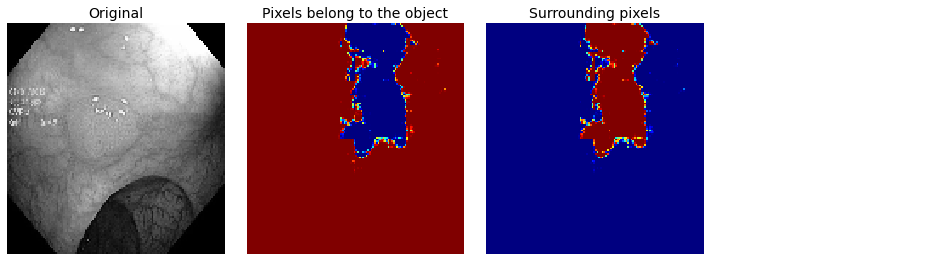

In [127]:
i_sample = 5
fig, AX = plt.subplots(1, 4, figsize=(13, (13-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_pred[i_sample, ..., 1], cmap=plt.cm.jet)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to the object", fontsize=14);
AX[2].set_title("Surrounding pixels", fontsize=14);

###  Testing on Custom data

In [128]:
import cv2
test_annotation_path ='data/mask_png//*.png'
test_image_path = 'data/images/*.jpg'
result_path='data/result/viz/'
label_names = np.array(sorted(glob(test_annotation_path)))
sample_names = np.array(sorted(glob(test_image_path)))
test_input_1 = input_data_process(utils.image_to_array(sample_names, size=128, channel=3))
test_target_1 = target_data_process(utils.image_to_array(label_names, size=128, channel=1))
y_pred_1 = (model.predict([test_input_1,]))

for i in range (len(label_names)):
    name=(os.path.basename(label_names[i]))
    cv2.imwrite(result_path+name,np.argmax(y_pred_1[i],axis=2)*255)
    

print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target_1, y_pred_1))))
acc = keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
acc.update_state(test_target_1,y_pred_1)
print('Testing set Accuracy = ',acc.result().numpy())



7/7 [==============================] - 1s 113ms/step
Testing set cross-entropy loss = 0.26241523027420044
Testing set Accuracy =  0.9788348


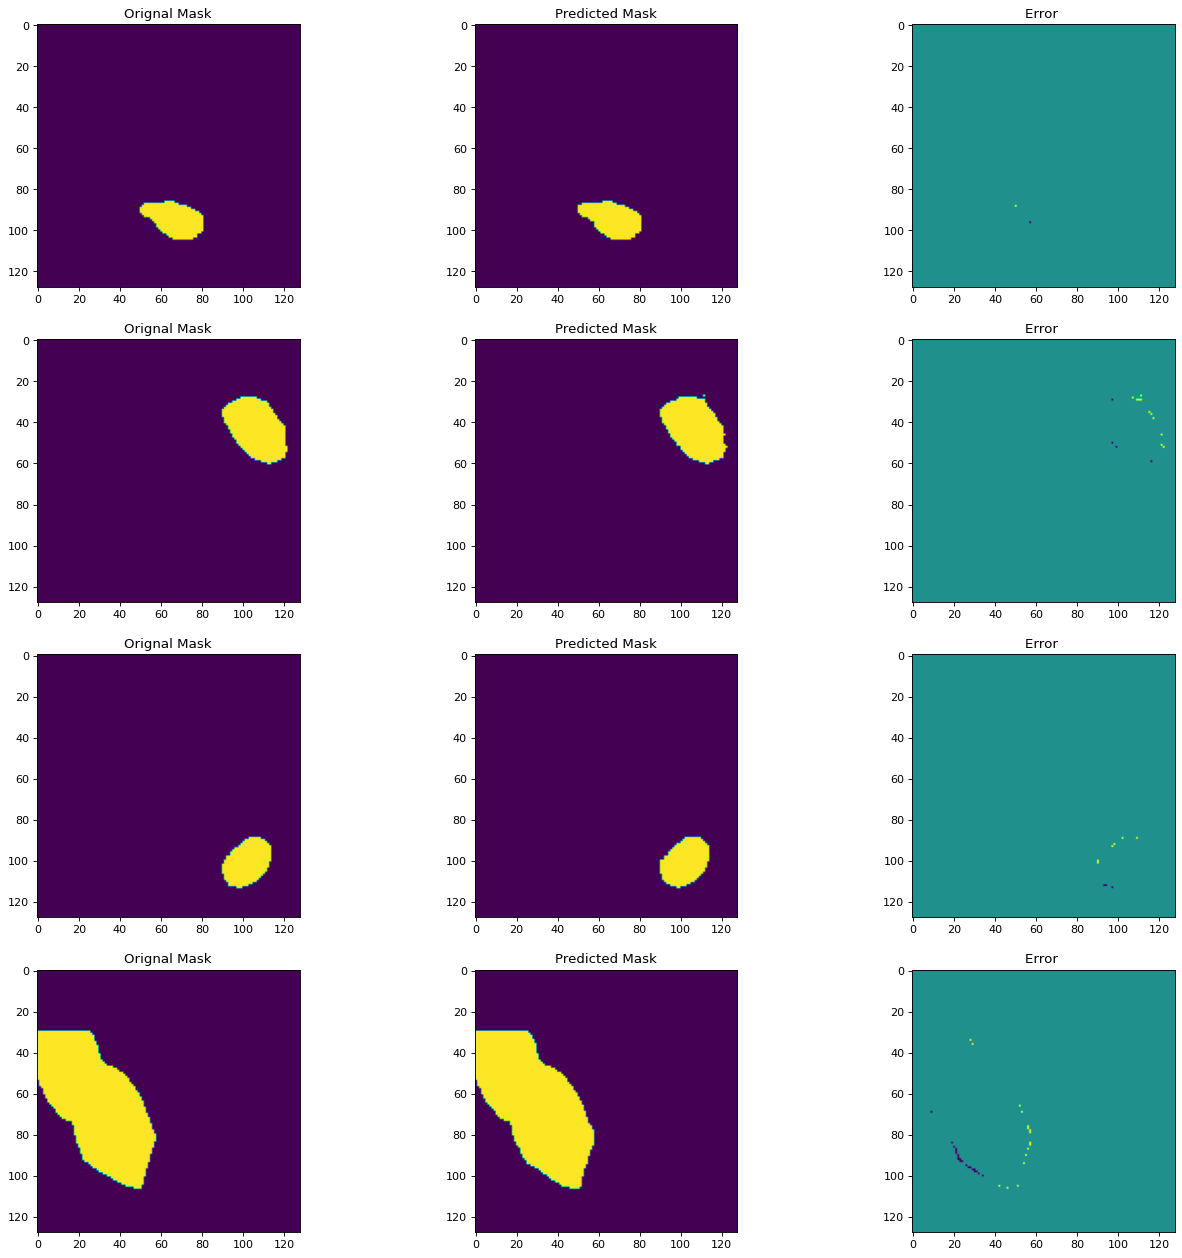

In [129]:
x=np.random.randint(0, high=len(label_names), size= 4, dtype=int)
a=1
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=80)

for i in range (len(x)):
    plt.subplot(4,3,a)
    plt.title('Orignal Mask')
    plt.imshow(np.argmax(test_target_1[x[i]],axis=2)*255)
    plt.subplot(4,3,a+1)
    plt.imshow(np.argmax(y_pred_1[x[i]],axis=2)*255)
    plt.title('Predicted Mask')
    Error=np.argmax(y_pred_1[x[i]],axis=2)*255-np.argmax(test_target_1[x[i]],axis=2)*255
    plt.subplot(4,3,a+2)
    plt.imshow(Error)
    plt.title('Error ')
    a=a+3
#plt.figure(figsize = (10,10))
plt.savefig('Results.png',transparent=True)
